In [1]:
import os
import random
import pandas as pd
import numpy as np
import mapclassify
import matplotlib.pyplot as plt
import seaborn as sb
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PowerTransformer
import h2o
from h2o.automl import H2OAutoML
from cartopy import crs as ccrs


Bad key "text.kerning_factor" on line 4 in
/home/moc0/miniconda3/envs/ml-fuel/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# Define plot size
plt.rcParams["figure.figsize"] = (15,5)

In [3]:
# Get current working directory
os.getcwd()
# Change current working directory to one folder up
os.chdir('../../')
# Check current working directory is as expected
os.getcwd()

'/home/moc0/ai-vegetation-fuel'

In [4]:
# H2O AutoML framework for benchmarking
h2o.init(max_mem_size = 32)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_291"; Java(TM) SE Runtime Environment (build 1.8.0_291-b10); Java HotSpot(TM) 64-Bit Server VM (build 25.291-b10, mixed mode)
  Starting server from /home/moc0/miniconda3/envs/ml-fuel/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpcvu7v9y3
  JVM stdout: /tmp/tmpcvu7v9y3/h2o_moc0_started_from_python.out
  JVM stderr: /tmp/tmpcvu7v9y3/h2o_moc0_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.1
H2O_cluster_version_age:,2 months and 7 days
H2O_cluster_name:,H2O_from_python_moc0_uoj5gn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,28.44 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"accepting new members, healthy"


# Load data

In [5]:
# Load raw train data
train = pd.read_csv(os.getcwd() + "/data/inputs/train_raw_interpTrue.csv",
                    dtype={'climatic_region':'category',
                           'biome':'category',
                           'GFEDregions':'category'})

# Load raw test data
test = pd.read_csv(os.getcwd() + "/data/inputs/test_raw_interpTrue.csv",
                   dtype={'climatic_region':'category',
                          'biome':'category',
                          'GFEDregions':'category'})

In [6]:
train = train.drop('Unnamed: 0', axis = 1)
test = test.drop('Unnamed: 0', axis = 1)

### Check distributions of outcome variable and features

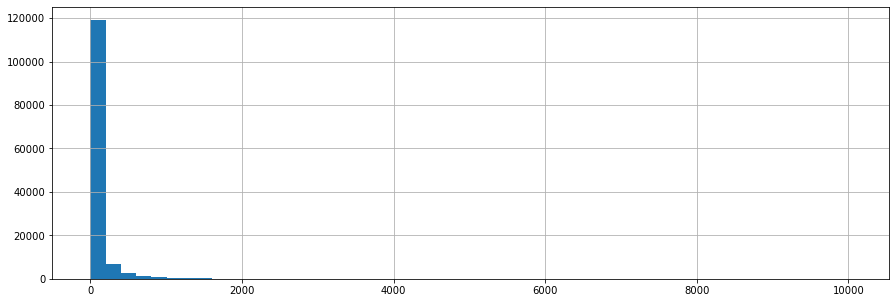

In [7]:
test['dry_matter'].hist(bins = 50)

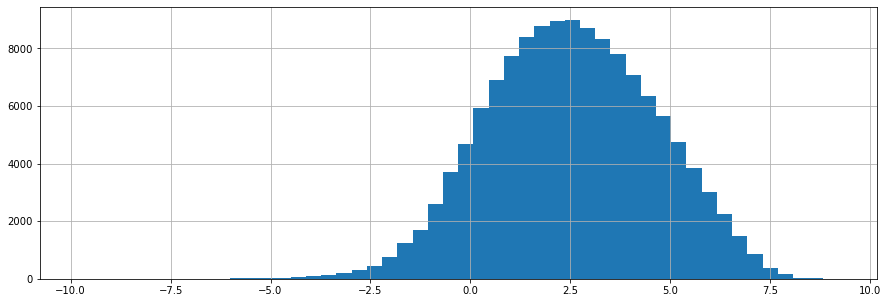

In [8]:
np.log(test['dry_matter']).hist(bins = 50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9660a25eb0>,
      dtype=object)

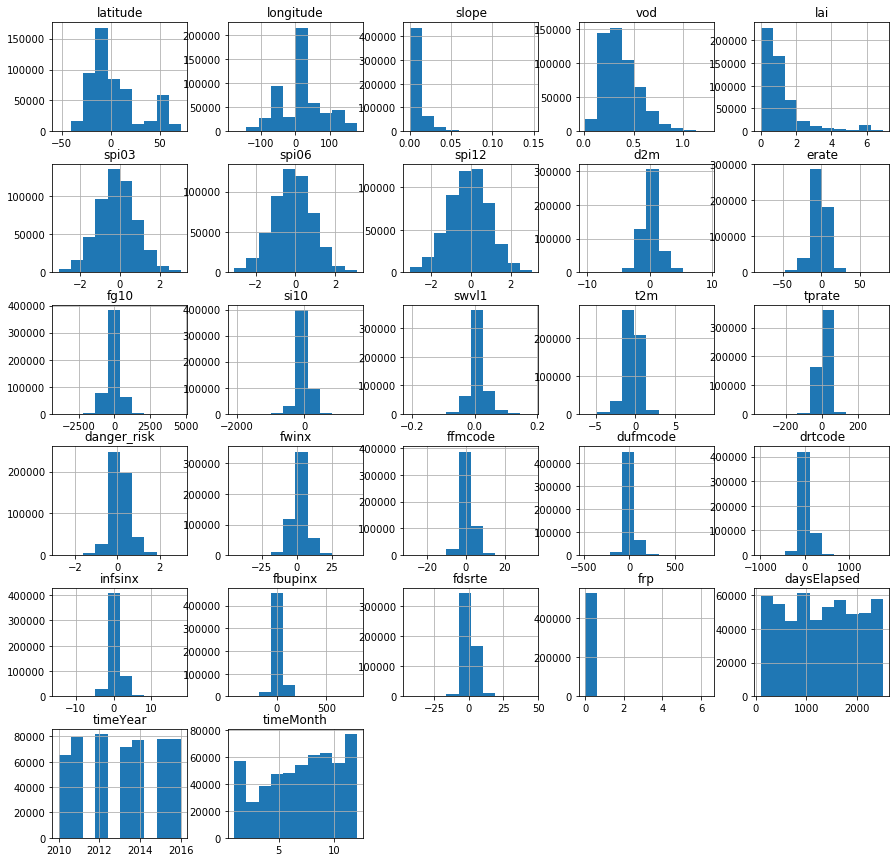

In [9]:
trainx = train.drop('dry_matter', axis = 1)
trainx.hist(figsize = (15,15))

In [24]:
# Log-transform outcome variable
train['log_dry_matter'] = np.log(train['dry_matter'])
test['log_dry_matter'] = np.log(test['dry_matter'])

## Model selection and further processing

Following the results of the benchmark tests, the final configuration selected is the one that uses log-transformed target and Y-J transformed continuous predictors. An extended training of this model is run below with a max runtime of 24 hours.

In [25]:
train

,latitude,longitude,dry_matter,climatic_region,biome,GFEDregions,slope,vod,lai,spi03,...,dufmcode,drtcode,infsinx,fbupinx,fdsrte,frp,daysElapsed,timeYear,timeMonth,log_dry_matter
0,-32.375,28.125,1.001038,3.0,1.0,9.0,0.014507,0.228241,0.222220,-0.398828,...,13.643188,109.829220,1.191657,22.684143,2.530905,0.000000,212,2010,8,0.001037
1,17.875,82.375,27.360060,4.0,5.0,12.0,0.024084,0.385490,0.555550,-0.349998,...,-43.599540,-57.730576,-3.418025,-41.623190,-7.454767,0.000000,1520,2014,3,3.309084
2,-31.625,28.375,3.641749,3.0,1.0,9.0,0.020789,0.275492,0.288886,-0.404686,...,-13.695341,-106.551190,-0.762760,-19.835646,-1.497616,0.000000,1277,2013,7,1.292464
3,13.375,37.125,17.883150,4.0,1.0,8.0,0.042149,0.256732,0.433329,-0.295313,...,-88.729330,26.709599,1.302401,-74.875960,3.221945,0.000000,455,2011,4,2.883859
4,8.125,-1.625,1.747495,4.0,1.0,8.0,0.006682,0.199548,0.722215,1.403907,...,-128.986300,-210.755860,-1.751252,-125.311600,-7.706358,0.007889,1492,2014,2,0.558184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530027,10.625,-13.875,36.482942,4.0,1.0,8.0,0.008239,0.415102,1.566651,0.874609,...,126.336510,63.899292,1.229383,116.538080,3.192863,0.015762,1216,2013,5,3.596845
530028,-15.375,34.625,1.640657,3.0,1.0,9.0,0.016233,0.205404,1.022212,0.112892,...,-13.123533,22.029633,-1.279937,-11.235716,-2.089784,0.000000,577,2011,8,0.495097
530029,11.875,36.625,13.193764,4.0,1.0,8.0,0.022857,0.218347,0.377774,1.757421,...,6.771729,19.831726,0.491823,4.540405,1.184292,0.000000,1096,2013,1,2.579744
530030,2.875,19.375,850.061983,4.0,5.0,8.0,0.002305,0.789469,1.566651,-0.131250,...,62.941635,53.213240,3.535935,56.135567,7.314124,0.003937,2191,2016,1,6.745309


In [26]:
# copy of datasets
train_yj = train.copy()
test_yj = test.copy()

train_yj

,latitude,longitude,dry_matter,climatic_region,biome,GFEDregions,slope,vod,lai,spi03,...,dufmcode,drtcode,infsinx,fbupinx,fdsrte,frp,daysElapsed,timeYear,timeMonth,log_dry_matter
0,-32.375,28.125,1.001038,3.0,1.0,9.0,0.014507,0.228241,0.222220,-0.398828,...,13.643188,109.829220,1.191657,22.684143,2.530905,0.000000,212,2010,8,0.001037
1,17.875,82.375,27.360060,4.0,5.0,12.0,0.024084,0.385490,0.555550,-0.349998,...,-43.599540,-57.730576,-3.418025,-41.623190,-7.454767,0.000000,1520,2014,3,3.309084
2,-31.625,28.375,3.641749,3.0,1.0,9.0,0.020789,0.275492,0.288886,-0.404686,...,-13.695341,-106.551190,-0.762760,-19.835646,-1.497616,0.000000,1277,2013,7,1.292464
3,13.375,37.125,17.883150,4.0,1.0,8.0,0.042149,0.256732,0.433329,-0.295313,...,-88.729330,26.709599,1.302401,-74.875960,3.221945,0.000000,455,2011,4,2.883859
4,8.125,-1.625,1.747495,4.0,1.0,8.0,0.006682,0.199548,0.722215,1.403907,...,-128.986300,-210.755860,-1.751252,-125.311600,-7.706358,0.007889,1492,2014,2,0.558184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530027,10.625,-13.875,36.482942,4.0,1.0,8.0,0.008239,0.415102,1.566651,0.874609,...,126.336510,63.899292,1.229383,116.538080,3.192863,0.015762,1216,2013,5,3.596845
530028,-15.375,34.625,1.640657,3.0,1.0,9.0,0.016233,0.205404,1.022212,0.112892,...,-13.123533,22.029633,-1.279937,-11.235716,-2.089784,0.000000,577,2011,8,0.495097
530029,11.875,36.625,13.193764,4.0,1.0,8.0,0.022857,0.218347,0.377774,1.757421,...,6.771729,19.831726,0.491823,4.540405,1.184292,0.000000,1096,2013,1,2.579744
530030,2.875,19.375,850.061983,4.0,5.0,8.0,0.002305,0.789469,1.566651,-0.131250,...,62.941635,53.213240,3.535935,56.135567,7.314124,0.003937,2191,2016,1,6.745309


In [27]:
# remove original dry matter
train_yj = train_yj.drop(['dry_matter'], axis = 1)
test_yj = test_yj.drop(['dry_matter'], axis = 1)

In [28]:
train_yj.columns.to_list()

['latitude',
 'longitude',
 'climatic_region',
 'biome',
 'GFEDregions',
 'slope',
 'vod',
 'lai',
 'spi03',
 'spi06',
 'spi12',
 'd2m',
 'erate',
 'fg10',
 'si10',
 'swvl1',
 't2m',
 'tprate',
 'danger_risk',
 'fwinx',
 'ffmcode',
 'dufmcode',
 'drtcode',
 'infsinx',
 'fbupinx',
 'fdsrte',
 'frp',
 'daysElapsed',
 'timeYear',
 'timeMonth',
 'log_dry_matter']

In [29]:
# non-numerical features
cat_features = ['climatic_region', 'biome', 'GFEDregions', 'log_dry_matter']

# numerical features
num_features = train_yj.columns.to_list()
for i in cat_features:
    num_features.remove(i)
num_features

climatic_region
biome
GFEDregions
log_dry_matter


['latitude',
 'longitude',
 'slope',
 'vod',
 'lai',
 'spi03',
 'spi06',
 'spi12',
 'd2m',
 'erate',
 'fg10',
 'si10',
 'swvl1',
 't2m',
 'tprate',
 'danger_risk',
 'fwinx',
 'ffmcode',
 'dufmcode',
 'drtcode',
 'infsinx',
 'fbupinx',
 'fdsrte',
 'frp',
 'daysElapsed',
 'timeYear',
 'timeMonth']

In [30]:
# apply transformation on numerical features
for i in num_features:
    
    # fit on training data column
    yj = PowerTransformer().fit(train_yj[[i]])
    
    # transform the training data column
    train_yj[i] = yj.transform(train_yj[[i]])
    
    # transform the testing data column
    test_yj[i] = yj.transform(test_yj[[i]])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9659ce7790>,
      dtype=object)

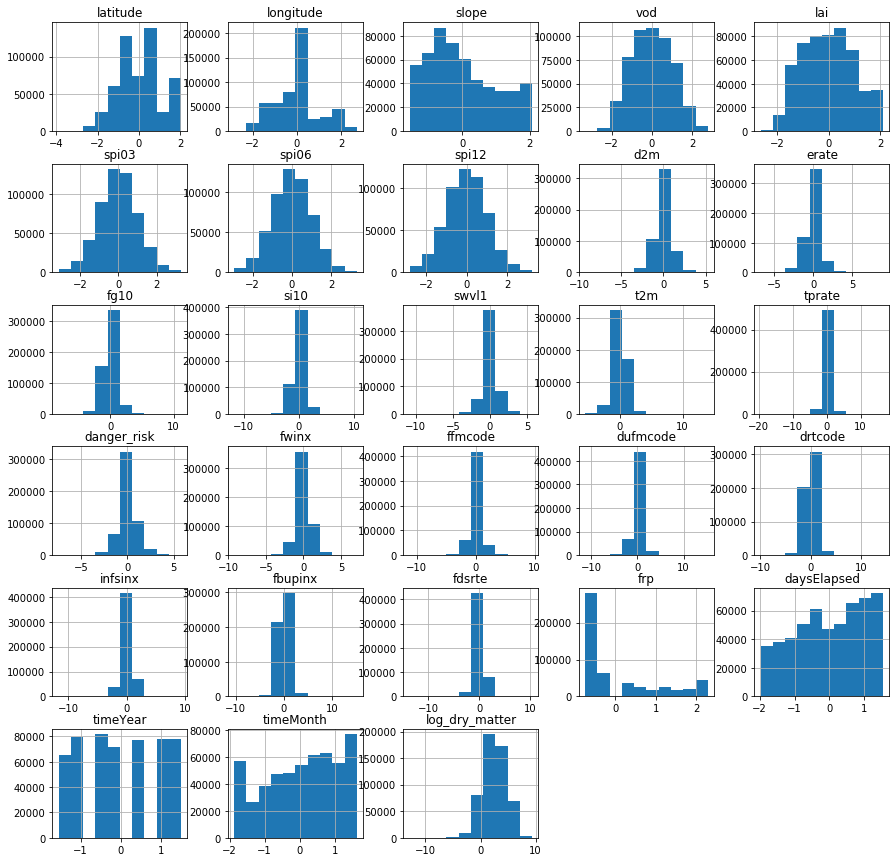

In [31]:
train_yj.hist(figsize = (15,15))

In [32]:
# Convert data to H2O frame
train_data = h2o.H2OFrame(train_yj)
test_data = h2o.H2OFrame(test_yj)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [33]:
# Define outcome variable
y = 'log_dry_matter'

In [34]:
# Define Regressor model
aml = H2OAutoML(max_runtime_secs = 6*60*60, seed = 1, stopping_metric = "mae",# stopping_tolerance = 0.01,
                preprocessing = ["target_encoding"])
    
# Fit
aml.train(y = y, training_frame = train_data)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [36]:
# View the AutoML Leaderboard - uses validation metrics
lb = aml.leaderboard
# lb.head()
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20210602_152347,1.27398,1.12871,1.27398,0.881734,nan
StackedEnsemble_BestOfFamily_AutoML_20210602_152347,1.30054,1.14041,1.30054,0.891759,nan
GBM_grid__1_AutoML_20210602_152347_model_56,1.32805,1.15241,1.32805,0.903818,nan
GBM_grid__1_AutoML_20210602_152347_model_44,1.36645,1.16895,1.36645,0.917675,nan
GBM_grid__1_AutoML_20210602_152347_model_25,1.3684,1.16979,1.3684,0.91936,nan
GBM_grid__1_AutoML_20210602_152347_model_16,1.37217,1.1714,1.37217,0.92082,nan
GBM_grid__1_AutoML_20210602_152347_model_34,1.37877,1.17421,1.37877,0.921186,nan
GBM_grid__1_AutoML_20210602_152347_model_69,1.38717,1.17778,1.38717,0.925436,nan
XGBoost_grid__1_AutoML_20210602_152347_model_29,1.38877,1.17846,1.38877,0.920054,nan
GBM_grid__1_AutoML_20210602_152347_model_61,1.3898,1.1789,1.3898,0.927744,nan


In [37]:
# Performance on test data
aml.leader.model_performance(test_data)


ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 1.2357754401528103
RMSE: 1.1116543708153224
MAE: 0.8683203640180931
RMSLE: NaN
R^2: 0.7174897631673076
Mean Residual Deviance: 1.2357754401528103
Null degrees of freedom: 132508
Residual degrees of freedom: 132491
Null deviance: 579630.3950803856
Residual deviance: 163751.36779920873
AIC: 404134.22990492743


In [38]:
# Predict using test data
pre = np.exp(aml.predict(test_data).as_data_frame())

# Get performance - transformed
# obs = np.exp(test_data[y].as_data_frame())
obs = test['dry_matter']
mean_absolute_error(obs, pre)

stackedensemble prediction progress: |████████████████████████████████████| 100%


43.95080117508513

In [39]:
# The leader model is stored here
# aml.leader

# Save the leader model
leadermodel_path = h2o.save_model(aml.leader, path = "/home/moc0/ai-vegetation-fuel/data/outputs", force = True)
print(leadermodel_path)

/home/moc0/ai-vegetation-fuel/data/outputs/StackedEnsemble_AllModels_AutoML_20210602_152347


In [ ]:
# Load the model
# saved_model = h2o.load_model(model_path)

# Visualise results

## Explainability

See https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html#explainability and https://docs.h2o.ai/h2o/latest-stable/h2o-docs/explain.html

In [ ]:
# Explain an AutoML object
exa = aml.explain(test_data)

## Time series

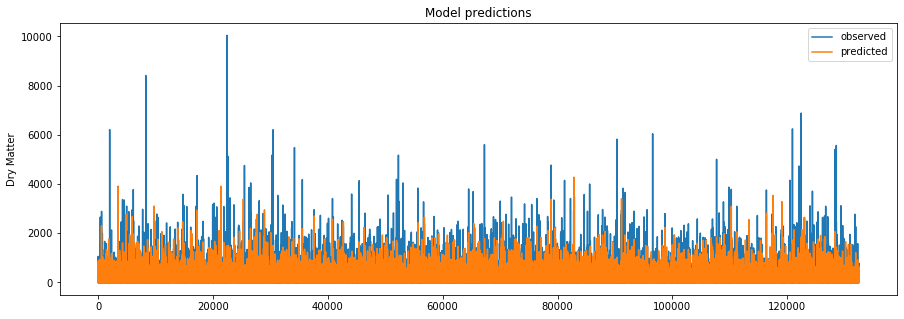

In [40]:
# Plot predictions
plt.plot(obs)
plt.plot(pre)
plt.title('Model predictions')
plt.ylabel('Dry Matter')
plt.xlabel('')
plt.legend(['observed', 'predicted'], loc='upper right')
plt.show()

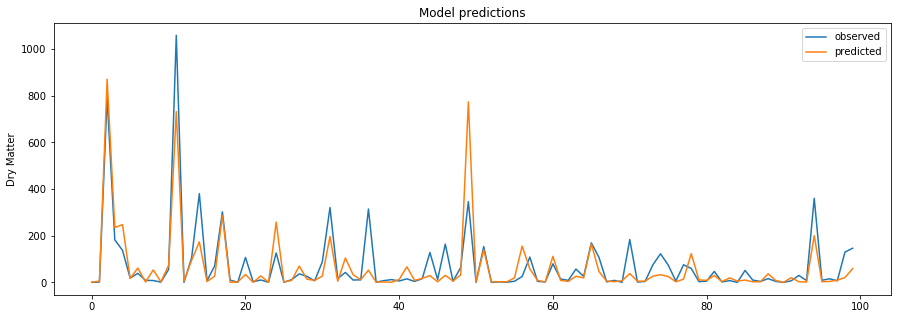

In [41]:
# Select a biome
idx = test['biome'] == 1

# Plot predictions
plt.plot(obs[0:100])
plt.plot(pre[0:100])
plt.title('Model predictions')
plt.ylabel('Dry Matter')
plt.xlabel('')
plt.legend(['observed', 'predicted'], loc='upper right')
plt.show()

## Map

In [55]:
# Add transformed back observations, prediction and residuals to the test data frame
test['prediction'] = pre
test['residual'] = test['prediction'] - test['dry_matter']
test['residual_sign'] = np.where(test['residual'] == 0, 'zero',
                                 np.where(test['residual'] > 0, 'positive', 'negative'))
test

,latitude,longitude,dry_matter,climatic_region,biome,GFEDregions,slope,vod,lai,spi03,...,fbupinx,fdsrte,frp,daysElapsed,timeYear,timeMonth,log_dry_matter,prediction,residual,residual_sign
0,-14.125,-43.625,0.637926,4.0,1.0,5.0,0.001862,0.280403,0.899991,0.124609,...,18.051723,1.645894,0.003937,1765,2014,11,-0.449533,1.205623,0.567697,positive
1,-15.875,18.375,2.027269,3.0,1.0,9.0,0.003352,0.235407,0.588883,0.878517,...,63.219906,4.600344,0.000000,1277,2013,7,0.706689,5.730401,3.703132,positive
2,5.375,28.875,791.847741,4.0,1.0,8.0,0.003062,0.531788,0.922213,-1.109352,...,5.097896,0.836676,0.417923,1795,2014,12,6.674369,870.396600,78.548858,positive
3,-18.875,33.375,182.594167,3.0,1.0,9.0,0.014721,0.364745,0.311108,-0.205468,...,-28.620920,-1.740059,0.055191,243,2010,9,5.207266,235.213835,52.619668,positive
4,7.625,-2.625,137.816458,4.0,1.0,8.0,0.003877,0.616257,0.999990,1.105078,...,-5.271719,6.633287,0.019714,1096,2013,1,4.925923,247.960096,110.143637,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132504,-13.875,22.125,11.398151,3.0,1.0,9.0,0.000576,0.312607,0.288886,-0.283592,...,22.556030,1.998066,0.003937,608,2011,9,2.433451,11.442623,0.044472,positive
132505,4.375,17.625,781.737678,4.0,1.0,8.0,0.008820,0.589686,0.877769,1.925390,...,-9.457446,-0.957595,0.023651,334,2010,12,6.661519,633.992950,-147.744728,negative
132506,-11.875,21.375,202.957233,3.0,1.0,9.0,0.000306,0.290317,0.266664,0.187110,...,-16.323260,0.064647,0.051254,2007,2015,7,5.312995,123.411331,-79.545902,negative
132507,18.625,-102.625,81.223411,4.0,1.0,3.0,0.043172,0.505241,0.399996,0.075781,...,50.202015,7.200427,0.011826,1216,2013,5,4.397204,26.305606,-54.917805,negative


In [56]:
# Group results averaging over all days for each point (lat,lon)
grouped_test = test.groupby(['latitude', 'longitude'],
                            as_index=False).agg({'dry_matter': ['mean'],
                                                 'prediction': ['mean'],
                                                 'residual': ['mean']})
grouped_test.columns = ['latitude', 'longitude', 'dry_matter', 'prediction', 'residual']
grouped_test.describe()

,latitude,longitude,dry_matter,prediction,residual
count,44997.000000,44997.000000,44997.000000,44997.000000,44997.000000
mean,12.484752,20.060212,71.796812,48.345149,-23.451663
std,29.955204,74.327638,199.257848,116.127974,137.472546
min,-48.375000,-162.625000,0.000054,0.032891,-7712.915662
25%,-13.375000,-48.375000,3.510049,3.424484,-14.455941
50%,7.375000,26.625000,14.104767,11.751523,-0.974226
75%,46.125000,77.125000,56.598447,42.235072,2.460570
max,72.125000,178.125000,8409.015059,3536.356650,2563.770738


In [48]:
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(grouped_test,
                       geometry=gpd.points_from_xy(x = grouped_test.longitude,
                                                   y = grouped_test.latitude))

In [49]:
# Get coastline
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

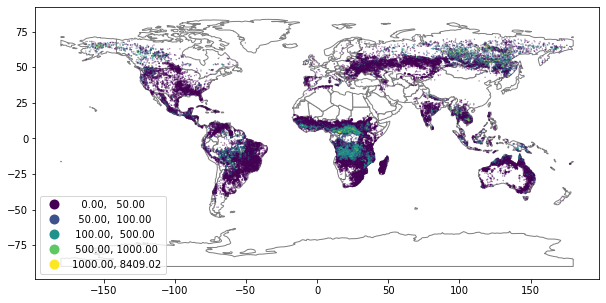

In [50]:
fig, ax = plt.subplots()

ax.set_aspect('equal')

world.plot(ax=ax, color='white', edgecolor='gray')

gdf.plot(column='dry_matter', #cmap='RdBu', 
         scheme="User_Defined",
         classification_kwds=dict(bins=[50, 100, 500, 1000]),
         markersize = 0.05,
         legend=True, 
         ax=ax)

plt.show()

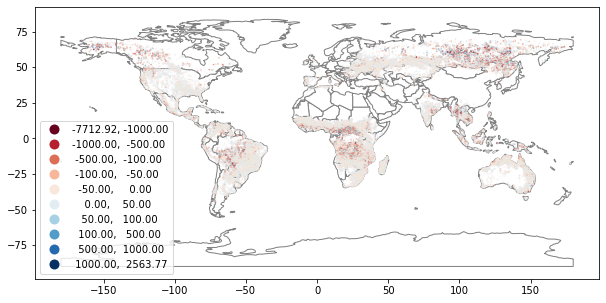

In [51]:
fig, ax = plt.subplots()

ax.set_aspect('equal')

world.plot(ax=ax, color='white', edgecolor='gray')

gdf.plot(column='residual', cmap='RdBu', 
         scheme="User_Defined",
         classification_kwds=dict(bins=[-1000, -500, -100, -50, 
                                        0, 
                                        50, 100, 500, 1000]),
         markersize = 0.05,
         legend=True, 
         ax=ax)

plt.show()

## Group statistics

In [69]:
# Group results averaging over all days for each point (lat,lon)
grouped_test2 = test.groupby(['biome', 'residual_sign'], as_index=False).agg({'dry_matter': ['mean'],
                                                                              'residual': ['mean']})
grouped_test2.columns = ['biome', 'residual_sign', 'dry_matter', 'residual']
grouped_test2['biome_names'] = np.repeat(['SA', 'SAOS', 'AG', 'AGOS', 'TF', 'PEAT', 'EF', 'EFOS'], 2)
grouped_test2

,biome,residual_sign,dry_matter,residual,biome_names
0,1.0,negative,115.477412,-53.573456,SA
1,1.0,positive,39.806498,22.269909,SA
2,2.0,negative,78.413193,-53.246304,SAOS
3,2.0,positive,12.541759,10.560666,SAOS
4,3.0,negative,18.678889,-12.769073,AG
5,3.0,positive,2.438159,2.529476,AG
6,4.0,negative,26.001652,-17.526012,AGOS
7,4.0,positive,3.536578,3.826918,AGOS
8,5.0,negative,183.521277,-110.850414,TF
9,5.0,positive,33.229409,26.917307,TF


In [75]:
np.arange(len(x))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

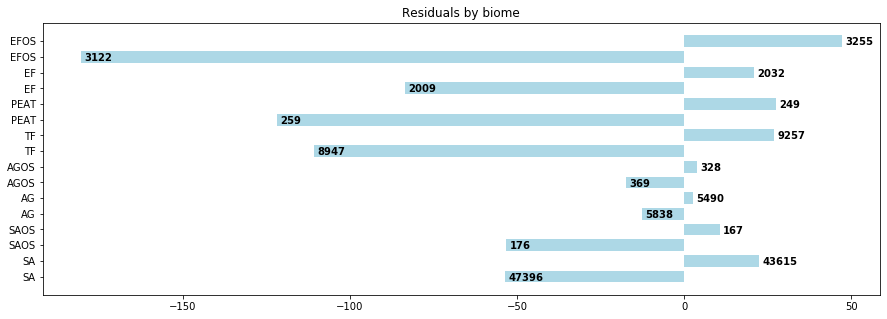

In [77]:
y = grouped_test2.residual
x = grouped_test2.biome_names
labels = test.groupby(['biome', 'residual_sign'], as_index=False).size()
labels = labels['size']
ind = np.arange(len(x))

fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ax.barh(ind, y, width, color="lightblue")
ax.set_yticks(ind)
ax.set_yticklabels(x, minor=False)
for i, v in enumerate(y):
    ax.text(v + 1, i - .25, str(labels[i]), color='black', fontweight='bold')
plt.title('Residuals by biome')
plt.xlabel('')
plt.ylabel('')      
plt.show()

In [78]:
# Group results averaging over all days for each point (lat,lon)
grouped_test3 = test.groupby(['GFEDregions', 'residual_sign'], as_index=False).agg({'dry_matter': ['mean'],
                                                                  'residual': ['mean']})
grouped_test3.columns = ['GFEDregions', 'residual_sign', 'dry_matter', 'residual']
grouped_test3['GFEDnames'] = np.repeat(['BONA', 'TENA', 'CEAM', 'NHSA', 'SHSA', 'EURO', 'MIDE',
                              'NHAF', 'SHAF', 'BOAS', 'CEAS', 'SEAS', 'EQAS', 'AUST'], 2)
grouped_test3

,GFEDregions,residual_sign,dry_matter,residual,GFEDnames
0,1.0,negative,209.658624,-134.614553,BONA
1,1.0,positive,38.043228,35.960635,BONA
2,10.0,negative,183.567437,-114.493660,TENA
3,10.0,positive,33.505774,30.474142,TENA
4,11.0,negative,30.487324,-22.360070,CEAM
5,11.0,positive,3.290619,3.637158,CEAM
6,12.0,negative,194.387791,-130.407205,NHSA
7,12.0,positive,24.309528,22.719844,NHSA
8,13.0,negative,150.308145,-104.627803,SHSA
9,13.0,positive,19.905047,21.071481,SHSA


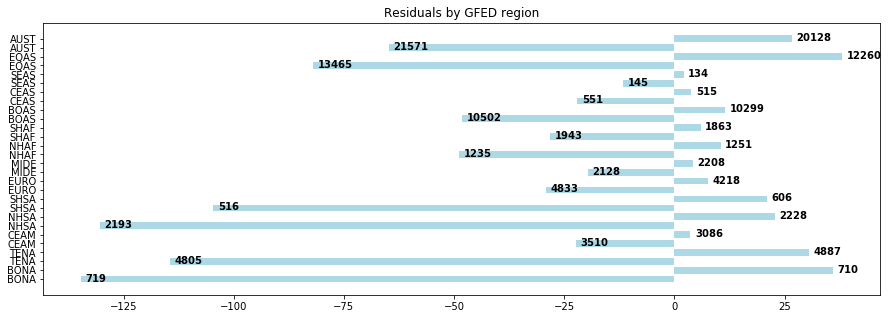

In [81]:
y = grouped_test3.residual
x = grouped_test3.GFEDnames
labels = test.groupby(['GFEDregions', 'residual_sign'], as_index=False).size()
labels = labels['size']
ind = np.arange(len(x))

fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ax.barh(ind, y, width, color="lightblue")
ax.set_yticks(ind)
ax.set_yticklabels(x, minor=False)
for i, v in enumerate(y):
    ax.text(v + 1, i - .25, str(labels[i]), color='black', fontweight='bold')
plt.title('Residuals by GFED region')
plt.xlabel('')
plt.ylabel('')      
plt.show()

# Resources

H2O AutoML:
- https://towardsdatascience.com/a-deep-dive-into-h2os-automl-4b1fe51d3f3e#:~:text=H2O%20AutoML%20functionalities&text=Necessary%20data%20pre%2Dprocessing%20capabilities,are%20tuned%20using%20cross%2Dvalidation.

Data transformations:
- https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/
- https://www.kaggle.com/product-feedback/164183
- https://medium.com/@patricklcavins/using-scipys-powertransformer-3e2b792fd712
- https://machinelearningmastery.com/power-transforms-with-scikit-learn/
- https://robjhyndman.com/hyndsight/transformations/
- https://stats.stackexchange.com/questions/1444/how-should-i-transform-non-negative-data-including-zeros